In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from webdriver_manager.chrome import ChromeDriverManager    # 매 번 크롬 드라이버를 설치할 필요없이 자동으로
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.alert import Alert
from tqdm import tqdm_notebook
from urllib.request import urlopen
import time
import requests
import os
from glob import glob
import shutil
import matplotlib.font_manager as fm
font_name = fm.FontProperties(fname="C:\\Windows\\Fonts\\malgun.ttf").get_name()
plt.rc("font", family=font_name)

import matplotlib as mlp
mlp.rcParams["axes.unicode_minus"] = False

전기간 관람객 수
개별 영화 관람객 수

1. 개봉 10일차까지 보이는 공통적인 패턴. 
2. 총관람객수 추이와 개별 영화 추이의 관계
    3.천만 영화 - 비천만영화
3. 개봉요일에 따른 차이 

3. 천만영화 상영 중일 떄의 전체 관람객 수 - 아닐 떄의 전체 관람객 수

3. 연휴와의 관계 
    3. 연휴를 많이 포함하는 영화의 관람객 수

4. 날씨와 총관람객 수의 관계


전기간 관람객 수 추이

In [2]:
daily_tot_movie_aud=pd.read_csv("../movie_DB/macro_envirment/audience1_preprocess1.csv", 
                                usecols=lambda column: column != "Unnamed: 0" )
daily_tot_movie_aud.head()


,연도,전체개봉편수,전체상영편수,전체매출액,전체관객수,요일
0,2004-01-01 00:00:00,1,7,727005000,113837,Thursday
1,2004-01-02 00:00:00,0,7,642276500,104357,Friday
2,2004-01-03 00:00:00,0,7,796519500,125234,Saturday
3,2004-01-04 00:00:00,0,7,763271000,120203,Sunday
4,2004-01-05 00:00:00,0,7,409269500,64180,Monday


In [3]:
daily_aud=daily_tot_movie_aud[["연도","전체관객수"]]
daily_aud.loc[:, "연도"] = pd.to_datetime(daily_aud["연도"], format="%Y-%m-%d %H:%M:%S")
daily_aud.columns=["날짜","전체관객수"]
daily_aud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7036 entries, 0 to 7035
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   날짜      7036 non-null   datetime64[ns]
 1   전체관객수   7036 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 110.1 KB


C:\Users\acorn\AppData\Local\Temp\ipykernel_5072\620729030.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_aud.loc[:, "연도"] = pd.to_datetime(daily_aud["연도"], format="%Y-%m-%d %H:%M:%S")


In [4]:
import datetime

# daily_aud["날짜"] = pd.to_datetime(daily_aud["날짜"], format="%Y-%m-%d %H:%M:%S").dt.date
print(daily_aud.info())
print(daily_aud.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7036 entries, 0 to 7035
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   날짜      7036 non-null   datetime64[ns]
 1   전체관객수   7036 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 110.1 KB
None
          날짜   전체관객수
0 2004-01-01  113837
1 2004-01-02  104357
2 2004-01-03  125234
3 2004-01-04  120203
4 2004-01-05   64180


개별 영화 데이터프레임 만들기

In [5]:
csvs=glob("../movie_DB/individual_trend/*.csv")

In [6]:
dataframes = {}

# Iterate through the file paths
for file_path in csvs:
    # Get the file name without the extension
    file_name = os.path.splitext(os.path.basename(file_path))[0]
    
    dataframes[file_name] = pd.read_csv(file_path,usecols=lambda column: column != "Unnamed: 0")

# Access a DataFrame using the file name
example_df = dataframes['겨울왕국']

In [7]:
dataframes["변호인"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   날짜           64 non-null     object 
 1   스크린수         64 non-null     int64  
 2   스크린점유율       64 non-null     float64
 3   상영횟수         64 non-null     int64  
 4   상영점유율        64 non-null     float64
 5   좌석수          64 non-null     int64  
 6   좌석점유율        64 non-null     float64
 7   좌석판매율        64 non-null     float64
 8   매출액          64 non-null     int64  
 9   매출액증감(전일대비)  64 non-null     int64  
 10  관객수          64 non-null     int64  
 11  관객수증감(전일대비)  64 non-null     int64  
 12  누적매출액        64 non-null     int64  
 13  누적관객수        64 non-null     int64  
 14  순위           64 non-null     int64  
dtypes: float64(4), int64(10), object(1)
memory usage: 7.6+ KB


In [8]:
movie_titles = list(dataframes.keys())
print(movie_titles)

['1987', '7번방의 선물', '검사외전', '겨울왕국 2', '겨울왕국', '공조', '과속스캔들', '관상', '광해, 왕이 된 남자', '괴물', '국가대표', '국제시장', '극한직업', '기생충', '도둑들', '디워', '명량', '미션임파서블-고스트프로토콜', '밀정', '백두산', '범죄도시2', '베를린', '베테랑', '변호인', '보헤미안 랩소디', '부산행', '설국열차', '수상한 그녀', '스파이더맨- 노 웨이 홈', '스파이더맨- 파 프롬 홈', '스파이더맨- 홈 커밍', '신과함께-인과 연', '신과함께-죄와 벌', '실미도', '써니', '아바타- 물의 길', '아바타', '아이언맨 3', '알라딘', '암살', '어벤져스- 에이지 오브 울트론', '어벤져스- 엔드게임', '어벤져스- 인피니티 워', '엑시트', '왕의 남자', '인터스텔라', '최종병기 활', '캡틴 아메리카- 시빌 워', '탑건- 매버릭', '태극기 휘날리며', '택시운전사', '트랜스포머 3', '트랜스포머- 패자의 역습', '트랜스포머', '한산- 용의 출현', '해운대', '해적- 바다로 간 산적', '히말라야']


In [9]:
modified_df={}
for name in movie_titles:
    modified_df[f"{name}"]=dataframes[f"{name}"][["날짜","관객수"]]
    modified_df[f"{name}"]["날짜"] = pd.to_datetime(modified_df[f"{name}"]["날짜"], format="%Y-%m-%d")
    modified_df[f"{name}"]=pd.merge(modified_df[f"{name}"],daily_aud)

C:\Users\acorn\AppData\Local\Temp\ipykernel_5072\1525063124.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modified_df[f"{name}"]["날짜"] = pd.to_datetime(modified_df[f"{name}"]["날짜"], format="%Y-%m-%d")
C:\Users\acorn\AppData\Local\Temp\ipykernel_5072\1525063124.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modified_df[f"{name}"]["날짜"] = pd.to_datetime(modified_df[f"{name}"]["날짜"], format="%Y-%m-%d")
C:\Users\acorn\AppData\Local\Temp\ipykernel_5072\1525063124.py:4: SettingWithCopyWarning: 
A value

In [10]:
print(modified_df["히말라야"].head())
print(daily_aud.head())

          날짜     관객수    전체관객수
0 2015-12-16  203173   444895
1 2015-12-17  190883   537556
2 2015-12-18  242838   613883
3 2015-12-19  422443  1134967
4 2015-12-20  445051  1147342
          날짜   전체관객수
0 2004-01-01  113837
1 2004-01-02  104357
2 2004-01-03  125234
3 2004-01-04  120203
4 2004-01-05   64180


In [11]:
cut_date = {}
for name in movie_titles:
    cut_date[f"{name}"] = dataframes[f"{name}"].iloc[0:30]

In [12]:
cut_date["해운대"].head()

,날짜,스크린수,스크린점유율,상영횟수,상영점유율,좌석수,좌석점유율,좌석판매율,매출액,매출액증감(전일대비),관객수,관객수증감(전일대비),누적매출액,누적관객수,순위
0,2009-07-22,537,0.206,3116,0.275,679117,0.333,0.251,1208362000,1193882000,170700,168386,1307090000,185599,1
1,2009-07-23,580,0.228,3238,0.286,714154,0.351,0.375,1869390500,661028500,267500,96800,3176480500,453099,1
2,2009-07-24,619,0.237,3479,0.294,766112,0.362,0.406,2257056500,387666000,310756,43256,5433537000,763855,1
3,2009-07-25,727,0.258,4048,0.325,870966,0.392,0.704,4397179000,2140122500,612950,302194,9830716000,1376805,1
4,2009-07-26,754,0.266,4008,0.333,861506,0.401,0.718,4451706500,54527500,618333,5383,14282422500,1995138,1


In [13]:
cut_date["해운대"]["누적관객수"].iloc[-1]

9427313

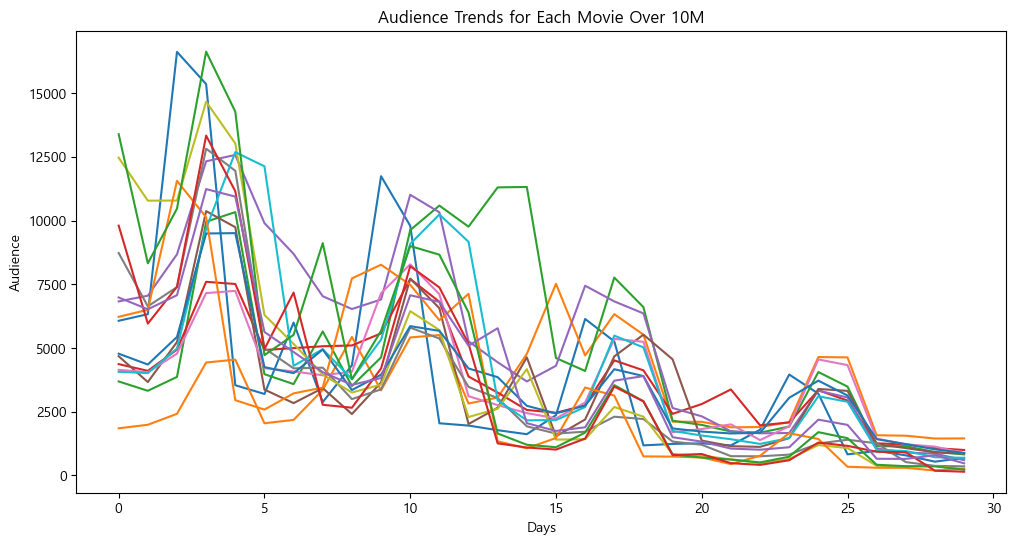

In [14]:
plt.figure(figsize=(12, 6))

for name in movie_titles:
    if cut_date[name]["누적관객수"].iloc[-1]>10000000:
        plt.plot(cut_date[name]["관객수"]/100, label=name)

        plt.xlabel('Days')
        plt.ylabel('Audience')
        plt.title('Audience Trends for Each Movie Over 10M')


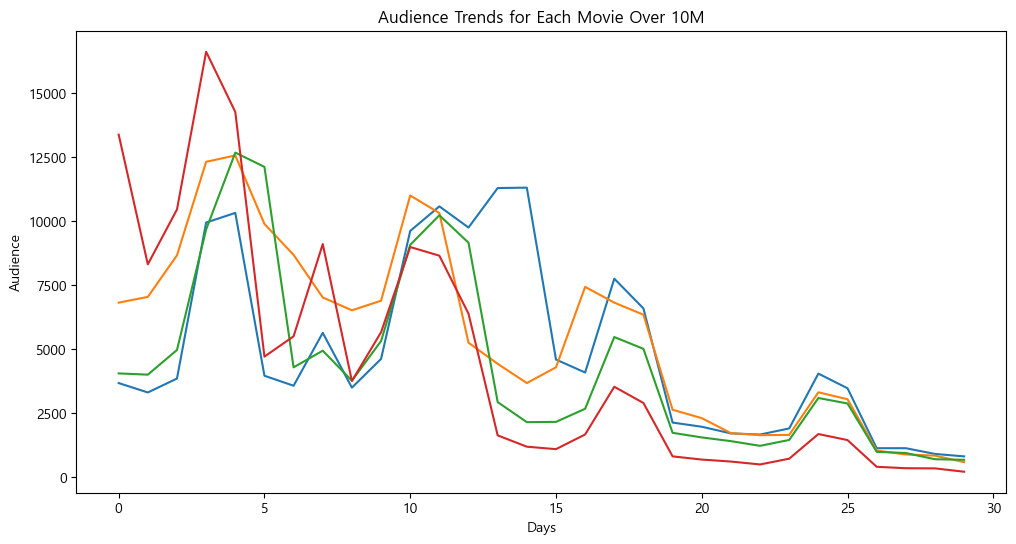

In [15]:

plt.figure(figsize=(12, 6))

for name in movie_titles:
    if cut_date[name]["누적관객수"].iloc[-1]>12812144:
        plt.plot(cut_date[name]["관객수"]/100, label=name)

        plt.xlabel('Days')
        plt.ylabel('Audience')
        plt.title('Audience Trends for Each Movie Over 10M')

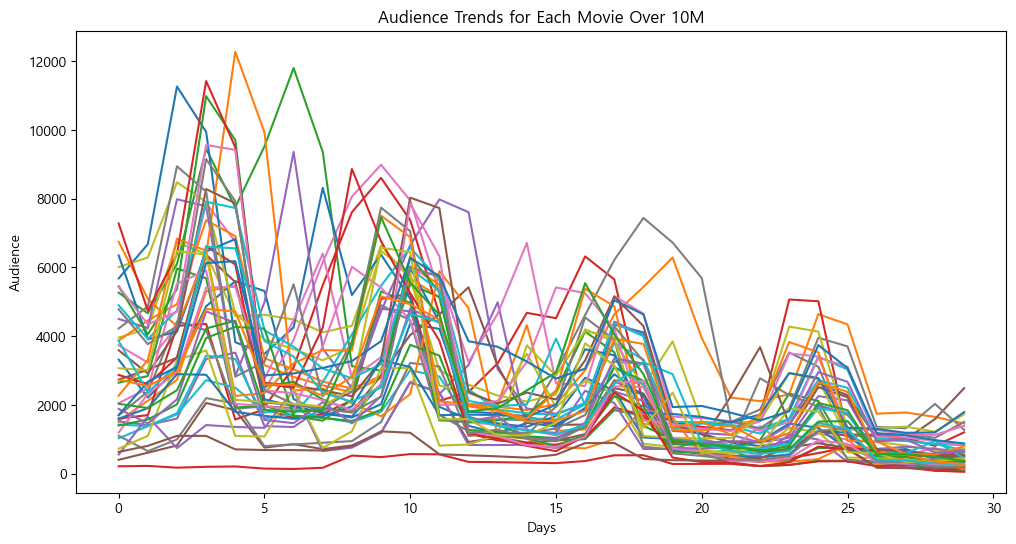

In [16]:
plt.figure(figsize=(12, 6))

for name in movie_titles:
    if cut_date[name]["누적관객수"].iloc[-1]<10000000:
        plt.plot(cut_date[name]["관객수"]/100, label=name)

        plt.xlabel('Days')
        plt.ylabel('Audience')
        plt.title('Audience Trends for Each Movie Over 10M')

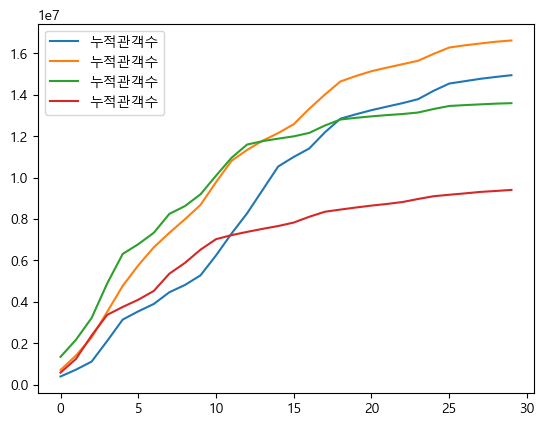

In [17]:
# fig, ax = plt.subplots()
# ax.plot(data=cut_date["극한직업"]["누적관객수"])
cut_date["극한직업"]["누적관객수"].plot()
cut_date["명량"]["누적관객수"].plot()
cut_date["어벤져스- 엔드게임"]["누적관객수"].plot()
cut_date["기생충"]["누적관객수"].plot()
plt.legend()

C:\Users\acorn\AppData\Local\Temp\ipykernel_5072\1345379381.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  combined_audience = pd.concat(cut_date.values(), axis=1).sum(axis=1)


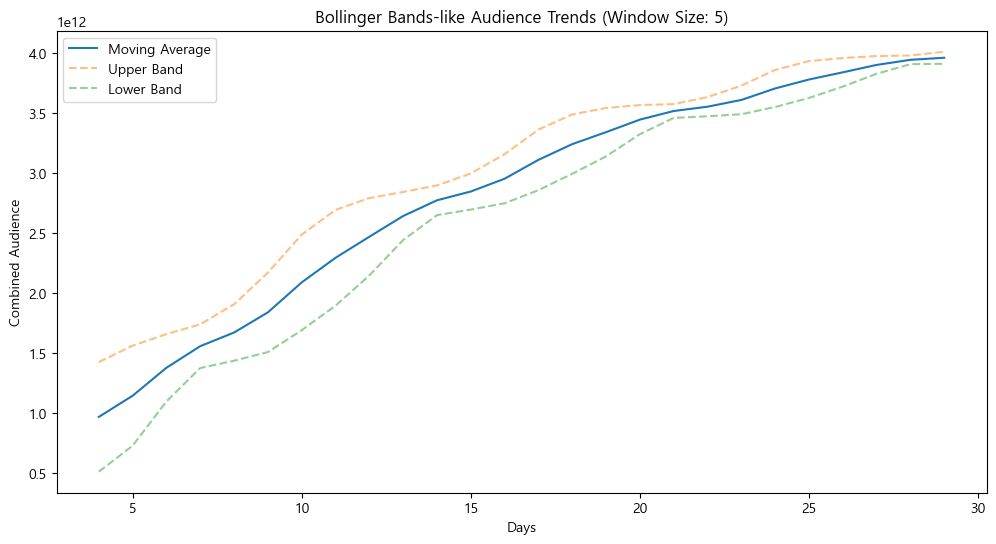

In [18]:
# Define the window size for the rolling mean and standard deviation
window_size = 5

# Combine the audience data for all movies
combined_audience = pd.concat(cut_date.values(), axis=1).sum(axis=1)

# Calculate the moving average and standard deviation
rolling_mean = combined_audience.rolling(window=window_size).mean()
rolling_std = combined_audience.rolling(window=window_size).std()

# Calculate the upper and lower Bollinger Bands
upper_band = rolling_mean + rolling_std
lower_band = rolling_mean - rolling_std

# Plot the moving average and Bollinger Bands
plt.figure(figsize=(12, 6))
plt.plot(rolling_mean, label="Moving Average")
plt.plot(upper_band, label="Upper Band", linestyle="--", alpha=0.5)
plt.plot(lower_band, label="Lower Band", linestyle="--", alpha=0.5)

plt.xlabel("Days")
plt.ylabel("Combined Audience")
plt.title(f"Bollinger Bands-like Audience Trends (Window Size: {window_size})")
plt.legend(loc="best")
plt.show()


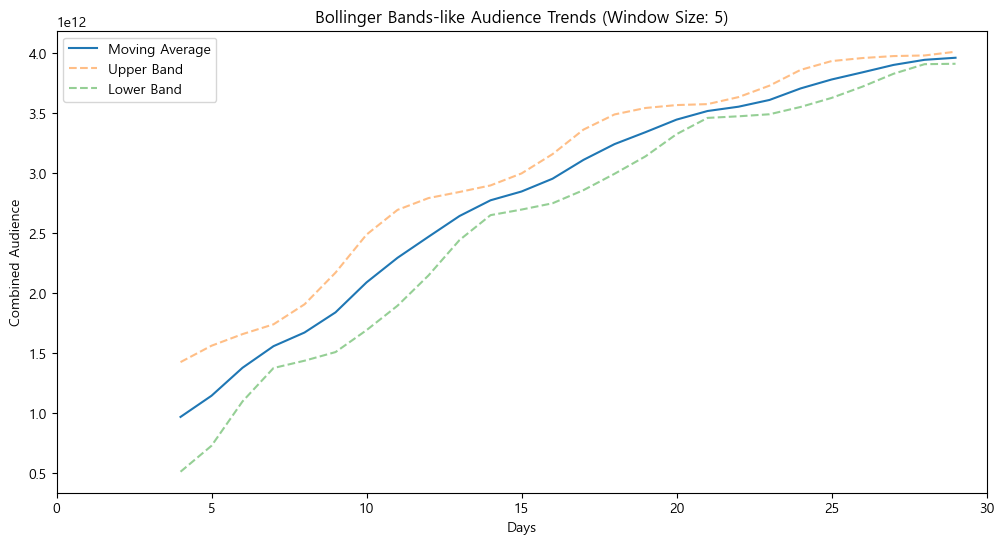

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(rolling_mean, label="Moving Average")
plt.plot(upper_band, label="Upper Band", linestyle="--", alpha=0.5)
plt.plot(lower_band, label="Lower Band", linestyle="--", alpha=0.5)

plt.xlim(0, len(combined_audience))  # Set the x-axis limits
plt.xlabel("Days")
plt.ylabel("Combined Audience")
plt.title(f"Bollinger Bands-like Audience Trends (Window Size: {window_size})")
plt.legend(loc="best")
plt.show()

In [40]:
for title in movie_titles:
    aud_mean = modified_df[title][["관객수"]].mean().round(2)
    total_mean = modified_df[title][["전체관객수"]].mean().round(2)
    print(f"{title}의 관객수: " + str(aud_mean[0]), "전체관객수: " 
          + str(total_mean[0]) + " (" + str(len(modified_df[title][["전체관객수"]])) + " Days)")
    print(aud_mean[0]/total_mean[0]*100)

1987의 관객수: 146673.92 전체관객수: 707671.69 (49 Days)
20.726266441434166
7번방의 선물의 관객수: 150335.81 전체관객수: 553166.98 (85 Days)
27.17729283118092
검사외전의 관객수: 225340.47 전체관객수: 644215.67 (43 Days)
34.97904203416846
겨울왕국 2의 관객수: 221382.02 전체관객수: 668038.35 (62 Days)
33.139118435341324
겨울왕국의 관객수: 148975.36 전체관객수: 605593.81 (69 Days)
24.599881560876582
공조의 관객수: 185642.6 전체관객수: 669483.17 (42 Days)
27.72924075148894
과속스캔들의 관객수: 67689.96 전체관객수: 412266.85 (120 Days)
16.41896747216033
관상의 관객수: 211734.65 전체관객수: 586607.07 (43 Days)
36.09480022121111
광해, 왕이 된 남자의 관객수: 119309.5 전체관객수: 532409.12 (103 Days)
22.40936443763398
괴물의 관객수: 171013.79 전체관객수: 419911.98 (63 Days)
40.726104075430285
국가대표의 관객수: 80955.92 전체관객수: 424444.79 (99 Days)
19.073368764875166
국제시장의 관객수: 167157.42 전체관객수: 680811.88 (85 Days)
24.552659098721957
극한직업의 관객수: 257700.37 전체관객수: 651334.62 (63 Days)
39.56497353080971
기생충의 관객수: 161977.74 전체관객수: 727086.94 (62 Days)
22.277630237726452
도둑들의 관객수: 185107.54 전체관객수: 693628.74 (70 Days)
26.686832497742234

In [58]:
cor_sum = 0
num_movies = len(movie_titles)

for title in movie_titles:
    correlation = modified_df[title]['관객수'].corr(modified_df[title]['전체관객수']).round(2)
    print(f"Correlation between 관객수 and 전체관객수 for {title}: {correlation}")
    cor_sum += correlation

average_correlation = cor_sum / num_movies
print(f"Average correlation for {num_movies} movies: {average_correlation:.2f}")


Correlation between 관객수 and 전체관객수 for 1987: 0.88
Correlation between 관객수 and 전체관객수 for 7번방의 선물: 0.88
Correlation between 관객수 and 전체관객수 for 검사외전: 0.73
Correlation between 관객수 and 전체관객수 for 겨울왕국 2: 0.61
Correlation between 관객수 and 전체관객수 for 겨울왕국: 0.91
Correlation between 관객수 and 전체관객수 for 공조: 0.83
Correlation between 관객수 and 전체관객수 for 과속스캔들: 0.72
Correlation between 관객수 and 전체관객수 for 관상: 0.86
Correlation between 관객수 and 전체관객수 for 광해, 왕이 된 남자: 0.5
Correlation between 관객수 and 전체관객수 for 괴물: 0.85
Correlation between 관객수 and 전체관객수 for 국가대표: 0.86
Correlation between 관객수 and 전체관객수 for 국제시장: 0.81
Correlation between 관객수 and 전체관객수 for 극한직업: 0.84
Correlation between 관객수 and 전체관객수 for 기생충: 0.49
Correlation between 관객수 and 전체관객수 for 도둑들: 0.63
Correlation between 관객수 and 전체관객수 for 디워: 0.92
Correlation between 관객수 and 전체관객수 for 명량: 0.79
Correlation between 관객수 and 전체관객수 for 미션임파서블-고스트프로토콜: 0.57
Correlation between 관객수 and 전체관객수 for 밀정: 0.69
Correlation between 관객수 and 전체관객수 for 백두산: 0.73
Correlation b

In [59]:
modified_df["태극기 휘날리며"]

,날짜,관객수,전체관객수
0,2004-02-05,63289,92584
1,2004-02-06,80911,116297
2,2004-02-07,109972,165883
3,2004-02-08,109834,166846
4,2004-02-09,70696,92968
...,...,...,...
101,2004-05-16,1287,174531
102,2004-05-17,611,62879
103,2004-05-18,615,59208
104,2004-05-19,607,64550
